<a href="https://colab.research.google.com/github/tuenv193176/test24_6/blob/main/test24_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import random
import joblib
import matplotlib.pyplot as plt


In [19]:
# Đọc dữ liệu
file_path = '/content/resonant_frequencies_729.csv'
data = pd.read_csv(file_path)
data.head()

,ls1 (mm),ls2 (mm),ls3 (mm),ws1 (mm),ws2 (mm),ws3 (mm),Frequency 1 (GHz),Frequency 2 (GHz),Frequency 3 (GHz)
0,7.50,9.0,7.75,0.50,1.5,0.25,2.55,5.40,NaN
1,7.75,9.0,7.75,0.50,1.5,0.25,2.50,5.30,NaN
2,8.00,9.0,7.75,0.50,1.5,0.25,2.50,5.35,NaN
3,7.50,9.0,7.75,0.75,1.5,0.25,2.50,5.35,NaN
4,7.75,9.0,7.75,0.75,1.5,0.25,2.50,5.30,5.9


In [3]:
#Kiểm tra số lượng trường hợp không có 3 tần số cộng hưởng
missing_f3 = data['Frequency 3 (GHz)'].isnull().sum()
total_entries = len(data)

missing_f3, total_entries
# 51 case --- remove

(52, 729)

In [4]:
# Loại bỏ các hàng bị khuyết tần số Frequency 3 (GHz)
data_cleaned = data.dropna(subset=['Frequency 3 (GHz)'])

# Tách dữ liệu thành biến đầu vào (X) và biến đầu ra (y)
X = data_cleaned[['ls1 (mm)', 'ls2 (mm)', 'ls3 (mm)', 'ws1 (mm)', 'ws2 (mm)', 'ws3 (mm)']]
y = data_cleaned[['Frequency 1 (GHz)', 'Frequency 2 (GHz)', 'Frequency 3 (GHz)']]

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


Random Forest Regression

In [5]:

# Khởi tạo mô hình Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_rf = rf_model.predict(X_test)

# Lưu mô hình Random Forest
joblib.dump(rf_model, 'rf_model.pkl')

# Đánh giá hiệu suất mô hình
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest - Mean Squared Error: {mse_rf}')
print(f'Random Forest - R-squared: {r2_rf}')


Random Forest - Mean Squared Error: 0.0018095397603485927
Random Forest - R-squared: 0.7264561671149102


Artificial Neural Networks (ANN)

In [6]:
# Khởi tạo mô hình ANN
ann_model = Sequential()
ann_model.add(Dense(units=32, activation='relu', input_dim=X_train_scaled.shape[1]))
ann_model.add(Dense(units=32, activation='relu'))
ann_model.add(Dense(units=3, activation='linear'))  # Output layer for 3 frequencies

# Compile mô hình
ann_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Sử dụng Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Huấn luyện mô hình với Early Stopping
history = ann_model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

# Lưu mô hình ANN
ann_model.save('ann_model.keras')


# Dự đoán trên tập kiểm tra
y_pred_ann = ann_model.predict(X_test_scaled)

# Đảo ngược chuẩn hóa để đánh giá hiệu suất mô hình
y_test_inverse = scaler_y.inverse_transform(y_test_scaled)
y_pred_ann_inverse = scaler_y.inverse_transform(y_pred_ann)

# Đánh giá hiệu suất mô hình ANN
mse_ann = mean_squared_error(y_test_inverse, y_pred_ann_inverse)
r2_ann = r2_score(y_test_inverse, y_pred_ann_inverse)


5/5 [==============================] - 0s 4ms/step


In [7]:
print(f'ANN - Mean Squared Error: {mse_ann}')
print(f'ANN - R-squared: {r2_ann}')

ANN - Mean Squared Error: 0.0011063960044572973
ANN - R-squared: 0.828198514138616


Test

In [8]:
# Chọn ngẫu nhiên 20 mẫu từ tập kiểm tra
random_indices = random.sample(range(X_test_scaled.shape[0]), 20)

# Lấy các mẫu ngẫu nhiên
X_test_random = X_test_scaled[random_indices]
y_test_random = y_test_scaled[random_indices]

# Dự đoán bằng mô hình Random Forest
X_test_random_df = pd.DataFrame(scaler_X.inverse_transform(X_test_random), columns=X.columns)
y_pred_rf_random = rf_model.predict(X_test_random_df)

# Dự đoán bằng mô hình ANN
y_pred_ann_random = ann_model.predict(X_test_random)

# Đảo ngược chuẩn hóa để so sánh
y_test_random_inverse = scaler_y.inverse_transform(y_test_random)
y_pred_rf_random_inverse = y_pred_rf_random
y_pred_ann_random_inverse = scaler_y.inverse_transform(y_pred_ann_random)

# Làm tròn kết quả đến 2 chữ số sau dấu phẩy
y_test_random_inverse = np.round(y_test_random_inverse, 2)
y_pred_rf_random_inverse = np.round(y_pred_rf_random_inverse, 2)
y_pred_ann_random_inverse = np.round(y_pred_ann_random_inverse, 2)

# In kết quả
print("Index\tTrue Frequencies\tRF Predicted Frequencies\tANN Predicted Frequencies")
for i, idx in enumerate(random_indices):
    true_freq = "\t".join(map(str, y_test_random_inverse[i]))
    rf_pred = "\t".join(map(str, y_pred_rf_random_inverse[i]))
    ann_pred = "\t".join(map(str, y_pred_ann_random_inverse[i]))
    print(f"{idx}\t[{true_freq}]\t[{rf_pred}]\t[{ann_pred}]")


1/1 [==============================] - 0s 23ms/step
Index	True Frequencies	RF Predicted Frequencies	ANN Predicted Frequencies
64	[2.35	5.15	5.75]	[2.33	5.14	5.78]	[2.34	5.14	5.77]
41	[2.35	4.95	5.6]	[2.35	5.03	5.64]	[2.34	4.99	5.6]
71	[2.4	5.15	5.7]	[2.38	5.18	5.72]	[2.38	5.15	5.71]
123	[2.3	5.05	5.7]	[2.34	5.05	5.69]	[2.3	5.04	5.69]
127	[2.45	5.1	5.9]	[2.45	5.14	5.9]	[2.45	5.12	5.9]
69	[2.4	5.2	5.9]	[2.4	5.19	5.87]	[2.41	5.18	5.87]
4	[2.4	5.1	5.8]	[2.42	5.14	5.81]	[2.42	5.12	5.77]
35	[2.4	5.0	5.6]	[2.37	5.02	5.63]	[2.38	5.01	5.63]
108	[2.5	5.2	5.85]	[2.49	5.14	5.84]	[2.49	5.18	5.85]
36	[2.4	5.2	5.95]	[2.42	5.19	5.93]	[2.41	5.13	5.94]
99	[2.5	5.0	5.75]	[2.48	5.04	5.79]	[2.48	5.06	5.81]
106	[2.45	5.1	5.75]	[2.43	5.07	5.76]	[2.43	5.09	5.8]
14	[2.35	5.15	5.75]	[2.35	5.1	5.68]	[2.34	5.09	5.73]
16	[2.35	5.05	5.65]	[2.35	5.03	5.65]	[2.35	5.01	5.64]
79	[2.35	5.05	5.7]	[2.33	5.02	5.65]	[2.33	5.0	5.65]
8	[2.35	5.1	5.75]	[2.33	5.06	5.73]	[2.32	5.07	5.73]
93	[2.4	5.2	5.9]	[2.4	5.18	5.86]	[2.4	5.1

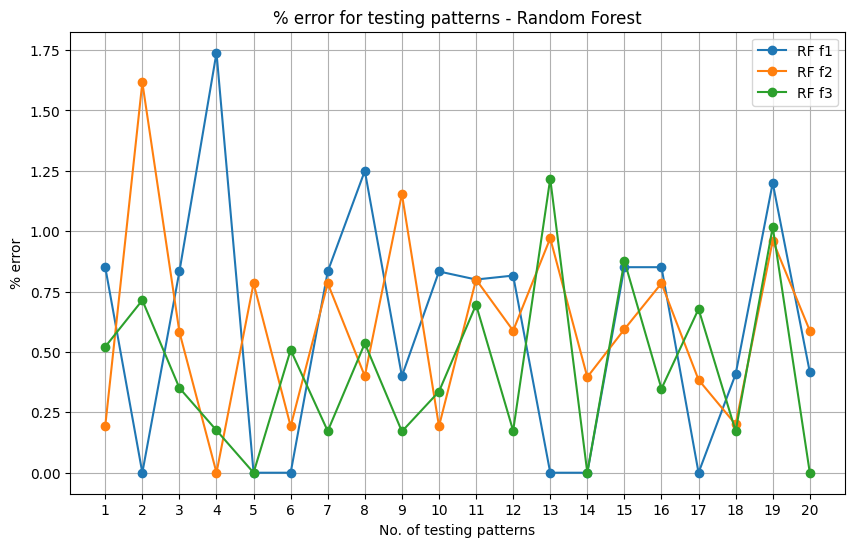

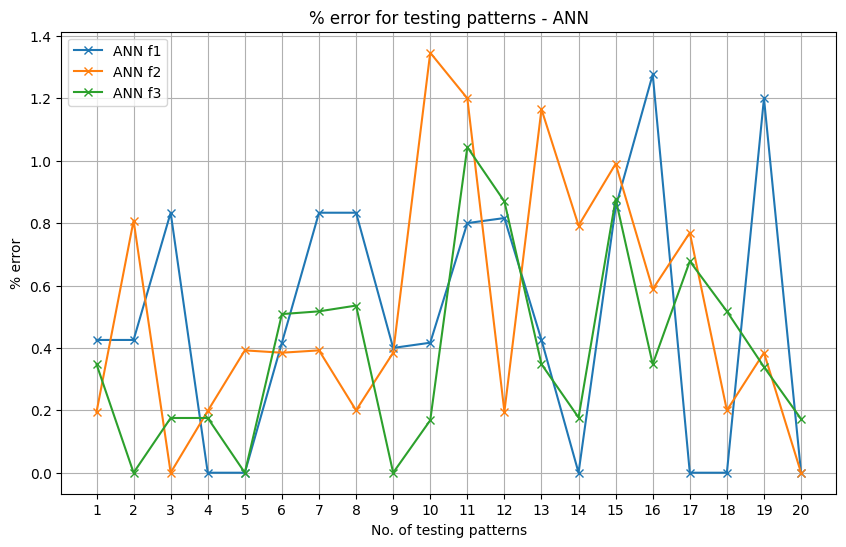

In [9]:
# Tính phần trăm lỗi cho mỗi tần số
percent_error_rf = np.abs((y_test_random_inverse - y_pred_rf_random_inverse) / y_test_random_inverse) * 100
percent_error_ann = np.abs((y_test_random_inverse - y_pred_ann_random_inverse) / y_test_random_inverse) * 100

# Vẽ biểu đồ cho mô hình Random Forest
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), percent_error_rf[:, 0], label='RF f1', marker='o', linestyle='-')
plt.plot(range(1, 21), percent_error_rf[:, 1], label='RF f2', marker='o', linestyle='-')
plt.plot(range(1, 21), percent_error_rf[:, 2], label='RF f3', marker='o', linestyle='-')
plt.xticks(range(1, 21))
plt.xlabel('No. of testing patterns')
plt.ylabel('% error')
plt.title('% error for testing patterns - Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ biểu đồ cho mô hình ANN
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), percent_error_ann[:, 0], label='ANN f1', marker='x', linestyle='-')
plt.plot(range(1, 21), percent_error_ann[:, 1], label='ANN f2', marker='x', linestyle='-')
plt.plot(range(1, 21), percent_error_ann[:, 2], label='ANN f3', marker='x', linestyle='-')
plt.xticks(range(1, 21))
plt.xlabel('No. of testing patterns')
plt.ylabel('% error')
plt.title('% error for testing patterns - ANN')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import joblib
import numpy as np
import pandas as pd
from keras.models import load_model

# Đường dẫn đến tệp dữ liệu mới và tệp lưu kết quả
new_data_path = '/content/test_predict rf.csv'

# Đọc dữ liệu mới
new_data = pd.read_csv(new_data_path)

# Tách dữ liệu mới thành biến đầu vào (X_new)
X_new = new_data[['ls1 (mm)', 'ls2 (mm)', 'ls3 (mm)', 'ws1 (mm)', 'ws2 (mm)', 'ws3 (mm)']]

# Giá trị thực tế
y_true = new_data[['Frequency 1 (GHz)', 'Frequency 2 (GHz)', 'Frequency 3 (GHz)']].values

# Chuẩn hóa dữ liệu mới
X_new_scaled = scaler_X.transform(X_new)

# Tải mô hình Random Forest đã lưu
rf_model = joblib.load('rf_model.pkl')

# Dự đoán bằng mô hình Random Forest
y_pred_rf_new = rf_model.predict(X_new)

# Tải mô hình ANN đã lưu
ann_model = load_model('ann_model.keras')

# Dự đoán bằng mô hình ANN
y_pred_ann_new_scaled = ann_model.predict(X_new_scaled)

# Đảo ngược chuẩn hóa cho dự đoán của ANN
y_pred_ann_new = scaler_y.inverse_transform(y_pred_ann_new_scaled)

# Làm tròn kết quả đến 2 chữ số sau dấu phẩy
y_pred_rf_new = np.round(y_pred_rf_new, 2)
y_pred_ann_new = np.round(y_pred_ann_new, 2)
y_true = np.round(y_true, 2)

# In kết quả
print("Index\tTrue Frequencies\tRF Predicted Frequencies\tANN Predicted Frequencies")
for i in range(len(X_new)):
    true_freq = "\t".join(map(str, y_true[i]))
    rf_pred = "\t".join(map(str, y_pred_rf_new[i]))
    ann_pred = "\t".join(map(str, y_pred_ann_new[i]))
    print(f"{i}\t[{true_freq}]\t[{rf_pred}]\t[{ann_pred}]")


1/1 [==============================] - 0s 128ms/step
Index	True Frequencies	RF Predicted Frequencies	ANN Predicted Frequencies
0	[2.4	5.1	5.75]	[2.36	5.12	5.68]	[2.39	5.1	5.71]
1	[2.45	5.2	5.85]	[2.45	5.14	5.79]	[2.45	5.18	5.83]
2	[2.45	5.2	5.85]	[2.44	5.1	5.75]	[2.45	5.16	5.82]
